## 1. 算法原理  
K-means algorithm

$c^{(i)}$ = index of cluster $(1, 2, \ldots, K)$ to which example $x^{(i)}$ is currently assigned  
$\mu_k$ = cluster centroids $k (\mu_k \in R^n)$  
Input:
- $K$(number of clusters)
- Training set {$x^{(1)},\ldots, x^(m)$}  
  Convention: $x(i) \in R^n$(drop x_0 = 1)

Randomly initialize $K$ cluster centroids $\mu_1, \mu_2,\ldots,\mu_k$  
Repeat{  
&emsp;&emsp;for i=1 to m  
&emsp;&emsp;&emsp;&emsp;$c^{(i)}$ $:=$ index (from $1$ to $K$) of cluster centroid closest to $x^{(i)}$  
&emsp;&emsp;for k=1 to m  
&emsp;&emsp;&emsp;&emsp;$\mu_k$ $:=$ average (mean) of points assigned to cluster $k$

}

Cost Function:
$$
J(c^{(i)},\ldots, c^{(m)}, \mu_1, \ldots, \mu_k) = \frac{1}{m}\sum^{m}_{i=1} \| x^{(i)} - \mu_{c^{(i)}} \| ^2
$$


## 2. 算法实现

### 2.1 自实现

参考了 [机器学习算法与Python实践之（五）k均值聚类（k-means）](https://blog.csdn.net/zouxy09/article/details/17589329)。  
我对其进行了代码优化，且有时特征 $(x_1, x_2,\ldots, x_n)$ 之间数量级差距太大，会导致在可视化时影响观察，故在此加入[归一化](https://www.brothereye.cn/python/329/#index-5)，将每个特征都使用零均值标准化。

In [2]:
# 多行输出结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm  # Create color  for visualization
from matplotlib.lines import Line2D  # Create marker for visualization
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

%matplotlib inline

np.random.seed(1)

In [19]:
# Create Samples
samNum = 100
dataSet = np.random.randn(samNum, 2)
dataSet[:, 1] = 100 * (dataSet[:, 1] + dataSet[:, 0])

In [13]:
def initCentroids(dataSet, K):
    '''Randowm initialize K cluster centroids.

    Randowm pick K training sample to initialize cluster centroids

    Args:
        dataSet: array. Training set {x_1, x_2,..., x_m}.
        K: int. number of cluster.

    Return:
        centroids: array. Initialized cluster centroids.
    '''
    numSamples, dim = dataSet.shape
    centroids = np.zeros((K, dim))
    index = 0
    picked_samples = []
    while True:
        if index >= K:
            break
        # random pick K training sample
        picked = np.random.randint(numSamples)
        # remove duplicate
        if picked not in picked_samples:
            centroids[index, :] = dataSet[picked, :]
            picked_samples.append(picked)
            index += 1
    return centroids


def euclidDistSq(vector1, vector2):
    '''calculate square of Euclidean distance'''
    return np.sum(np.square(vector1 - vector2))


def minMaxNorm(dataSet_org):
    '''min-max normalization'''
    numSamples, dim = dataSet_org.shape
    dataSet_norm = np.zeros((numSamples, dim), dtype=np.float32)
    minData = np.min(dataSet_org, axis=0)
    maxData = np.max(dataSet_org, axis=0)
    for ii in range(dim):
        dataSet_norm[:, ii] = (dataSet_org[:, ii] - minData[ii]) / (maxData[ii] - minData[ii])

    return dataSet_norm


def zScoreNorm(dataSet_org):
    '''Z score normalization'''
    numSamples, dim = dataSet_org.shape
    dataSet_norm = np.zeros((numSamples, dim), dtype=np.float32)
    mu = np.average(dataSet_org, axis=0)
    sigma = np.std(dataSet_org, axis=0)
    for ii in range(dim):
        dataSet_norm[:, ii] = (dataSet_org[:, ii] - mu[ii]) / sigma[ii]

    return dataSet_norm


def kmeans(dataSet, K):
    '''Randowm initialize K cluster centroids.

    Randowm pick K training sample to initialize cluster centroids

    Args:
        dataSet: array. Training set {x_1, x_2,..., x_m}.
        K: int. number of cluster.

    Return:
        centroids: array. cluster centroids.
        clusterAssigned: array. Cluster assignment.
            First column is cluster's index,
            Second column is distance between centroid and assigned sample.
    '''
    numSamples = dataSet.shape[0]
    clusterAssigned = np.full((numSamples, 2), fill_value=np.Inf)

    # first as all: initialize cluster centroids
    centroids = initCentroids(dataSet, K)

    clusterChanged = True
    while clusterChanged:
        # Step 1: Cluster assigned.
        for ii in range(numSamples):
            # 1.1: For each centroid, calculate its dist to sample
            for k in range(K):
                distSq = euclidDistSq(dataSet[ii, :], centroids[k, :])
                # 1.2: Assign cluster centroid
                if distSq < clusterAssigned[ii, 1]:
                    clusterAssigned[ii, :] = k, distSq

        # Step 2: Move centroids
        # 2.1 Backup last cendroids
        lastCentroids = centroids.copy()
        for k in range(K):
            pointsInCluster = dataSet[clusterAssigned[:, 0] == k]
            centroids[k, :] = np.mean(pointsInCluster, axis=0)

        # Determine if the algorithm has converged
        clusterChanged = not (centroids == lastCentroids).all()

    print('K means algorithm finished!')
    return centroids, clusterAssigned


def visualizeCluster(dataSet, K, centroids, clusterAssigned):
    numSamples, dim = dataSet.shape
    assert dim == 2, 'dataSet must be 2-Dimension'

    rainbow = cm.get_cmap('rainbow', lut=5)
    marker = list(Line2D.markers.keys())[1:-4]  # first marker is comma, drop it.
    assert K <= len(marker), "K is too large! Markers is not enough!"

    # draw all samples
    for ii in range(numSamples):
        markIndex = int(clusterAssigned[ii, 0])
        plt.scatter(dataSet[ii, 0], dataSet[ii, 1],
                    color=rainbow(markIndex), alpha=0.9)

    # draw the centroids
    for ii in range(K):
        plt.scatter(centroids[ii, 0], centroids[ii, 1],
                    facecolor=rainbow(ii), edgecolor='k',
                    marker=marker[ii], s=150, linewidth=2)

    # plt.show()  # Script should be uncomment


未归一化：

K means algorithm finished!


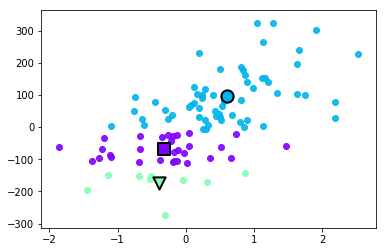

In [20]:
centroids, clustAssing = kmeans(dataSet, 3)
visualizeCluster(dataSet, 3, centroids, clustAssing)

> 未归一化的数据，由于 x1 的范围是[-2, 2]，而 x2 范围是 [-300, 300], 数量级差距太大。可视化后很难看出真实的情况。对于这种各特征数量级差距太大时应该使用归一化。

归一化后：

K means algorithm finished!


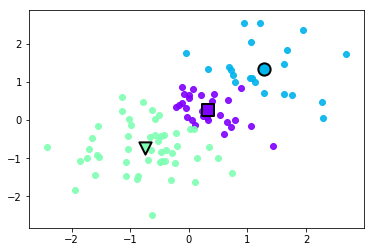

In [21]:
# norm_dataset = minMaxNorm(dataSet)
dataset_norm = zScoreNorm(dataSet)
centroids, clustAssing = kmeans(dataset_norm, 3)
visualizeCluster(dataset_norm, 3, centroids, clustAssing)

### 2.2 Scikit-learn

[sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) 
。  


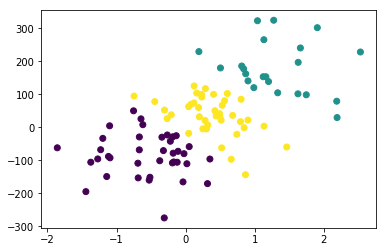

In [22]:
y_pred = KMeans(n_clusters=3, random_state=1).fit_predict(dataset_norm)
plt.scatter(dataSet[:, 0], dataSet[:, 1], c=y_pred);

Scikit-learn 里有生成数据的函数，[Samples generator](https://scikit-learn.org/stable/modules/classes.html#samples-generator)。生成高斯分布的斑点：[make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs)。官方文档的一个例子：

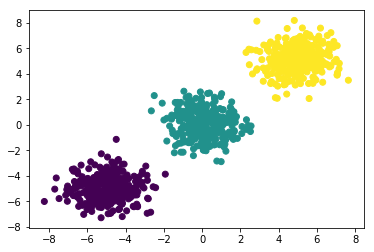

In [23]:
n_samples = 1000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)
# X: The generated samples. y: The integer labels for cluster membership of each sample.
plt.scatter(X[:, 0], X[:, 1], c=y);

K means algorithm finished!


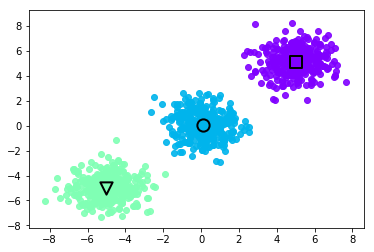

In [28]:
# 不使用归一化。因为极值接近。
centroids, clustAssing = kmeans(X, n_bins)
visualizeCluster(X, n_bins, centroids, clustAssing)

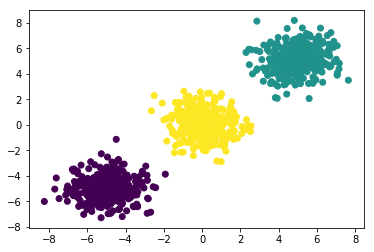

In [32]:
y_pred = KMeans(n_clusters=n_bins, random_state=1).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred);

自己写的函数聚类效果很差，需要运行多次才能出现和理想的结果一样。

## 3. 绘制动态图
将聚类的过程整个都可视化出来。
代码如下，这段代码要保存成 .py 来执行，不要在 jupyter notebook系列 中运行，代码在评论区可下载。运行结果示意图：![kmeans](kmeans.gif)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D


class KMeans(object):
    '''K means algorithm.

    Attributes:
        dataSet_org: array. Training set {x_1, x_2,..., x_m}.
        K: int. number of cluster.
        showStep: bool. whether to visualize.
    '''

    def __init__(self, dataSet_org, K, showStep=False):
        self.dataSet = self.zScoreNorm(dataSet_org)  # normalize data
        self.numSamples, self.dim = self.dataSet.shape
        self.K = K

        self.clusterAssigned = np.full((self.numSamples, 2), fill_value=np.Inf)
        # First as all: initialize cluster centroids
        self.centroids = self.initCentroids()

        if showStep:
            if self.dim != 2:
                self.showStep = False
                print('DataSet must be 2-Dimension for visualizing!')
            # create color
            self.rainbow = cm.get_cmap('rainbow', lut=5)
            # create marker
            self.marker = list(Line2D.markers.keys())[1:-4]
            # first marker is comma, drop it.
            if self.K > len(self.marker):
                self.showStep = False
                print("K is too large! Markers is not enough!")
            self.showStep = True

    def run(self):
        '''Execute K means algorithm'''
        if self.showStep:
            plt.ion()
            self.visual(self.dataSet, color='k', alpha=0.9)
            for k in range(self.K):
                self.visual(self.centroids[k, :],
                            facecolor=self.rainbow(k), edgecolor='k',
                            marker=self.marker[k], s=150, linewidth=2)
                plt.text(self.centroids[k, 0],
                         self.centroids[k, 1],
                         s='0',
                         horizontalalignment='center',
                         verticalalignment='center',
                         color=1.0 - np.array(self.rainbow(k)[0:3]))
                # text box uses the opposite color to centroid's color
        move_cnt = 1
        clusterChanged = True
        while clusterChanged:
            # Step 1: Cluster assigned.
            for ii in range(self.numSamples):
                # 1.1: For each centroid, calculate its dist to sample
                for k in range(self.K):
                    distSq = self.euclidDistSq(self.dataSet[ii, :],
                                               self.centroids[k, :])
                    # 1.2: Assign cluster centroid
                    if distSq < self.clusterAssigned[ii, 1]:
                        self.clusterAssigned[ii, :] = k, distSq
                        # show every step of assignment
                        if self.showStep:
                            self.visual(self.dataSet[ii, :],
                                        color=self.rainbow(k), alpha=0.9)

            # Step 2: Move centroids
            # 2.1 Backup last cendroids
            lastCentroids = self.centroids.copy()
            for k in range(self.K):
                pointsInCluster = self.dataSet[self.clusterAssigned[:, 0] == k]
                self.centroids[k, :] = np.mean(pointsInCluster, axis=0)

                if self.showStep:
                    self.visual(self.centroids[k, :],
                                facecolor=self.rainbow(k), edgecolor='k',
                                marker=self.marker[k], s=150, linewidth=2)
                    plt.text(self.centroids[k, 0],
                             self.centroids[k, 1],
                             s=str(move_cnt),
                             horizontalalignment='center',
                             verticalalignment='center',
                             color=1.0 - np.array(self.rainbow(k)[0:3]))
                # text box uses the opposite color to centroid's color

            # Determine if the algorithm has converged
            clusterChanged = not (self.centroids == lastCentroids).all()
            move_cnt += 1

        print('K means algorithm finished!')
        plt.ioff()
        plt.show()

    def initCentroids(self):
        '''Random initialize K cluster centroids.'''
        centroids = np.zeros((self.K, self.dim))
        index = 0
        picked_samples = []
        while True:
            if index >= self.K:
                break
            # random pick K training sample
            picked = np.random.randint(self.numSamples)
            # remove duplicate
            if picked not in picked_samples:
                centroids[index, :] = self.dataSet[picked, :]
                picked_samples.append(picked)
                index += 1
        return centroids

    def euclidDistSq(self, v1, v2):
        '''calculate square of Euclidean distance'''
        return np.sum(np.square(v1 - v2))

    def minMaxNorm(self, dataSet_org):
        '''min-max normalization'''
        numSamples, dim = dataSet_org.shape
        dataSet_norm = np.zeros((numSamples, dim), dtype=np.float32)
        minData = np.min(dataSet_org, axis=0)
        maxData = np.max(dataSet_org, axis=0)
        for ii in range(dim):
            dataSet_norm[:, ii] = (dataSet_org[:, ii] - minData[ii]) /\
                (maxData[ii] - minData[ii])

        return dataSet_norm

    def zScoreNorm(self, dataSet_org):
        '''Z score normalization'''
        numSamples, dim = dataSet_org.shape
        dataSet_norm = np.zeros((numSamples, dim), dtype=np.float32)
        mu = np.average(dataSet_org, axis=0)
        sigma = np.std(dataSet_org, axis=0)
        for ii in range(dim):
            dataSet_norm[:, ii] = (dataSet_org[:, ii] - mu[ii]) / sigma[ii]

        return dataSet_norm

    def visual(self, data, **kwarg):
        if data.ndim == 1:
            data = data[np.newaxis, :]
        plt.scatter(data[:, 0], data[:, 1], **kwarg)
        plt.pause(0.0001)


if __name__ == '__main__':
    # Create Samples
    samNum = 100
    dataSet = np.random.randn(samNum, 2)
    dataSet[:, 1] = 100 * (dataSet[:, 1] + dataSet[:, 0])
    kmean_model = KMeans(dataSet, 4, showStep=True)
    kmean_model.run()


## 4. 函数总结
上面用到的一些函数总结(用了库的缩写)：
- `axes`: numpy 中 `axis=0` 表示对列操作，`axis=1` 表示对行操作。
- `A[:, np.newaxis]`: 产生拷贝：对 A 矩阵右边扩一空列  
- `np.random.randint()`: 整型的高斯分布的随机数  
- `np.square()`: 平方  
- `np.sum/min/max/average/std()`: 求和/最小/最大值/均值/方差，  
- `np.full((m, n), fill_value)`: 使用fill_value，填充尺寸 MXN array  
- `np.Inf`: numpy 生成的无穷大值  
- `cm.get_cmap(mapName, lut)`: 引用 mapName 的色彩表，长度为 lut  
- `Line2D.markers`: 返回一个字典，字典的键就是需要使用的 marker，值是其的说明。官方文档 [marker#module-matplotlib.markers](https://matplotlib.org/api/markers_api.html?highlight=marker#module-matplotlib.markers)  
- `plt.scatter(x, y, facecolor, edgecolor, marker, s, linewidth)`: facecolor: 点的前景颜色，edgecolor: 点的轮廓线颜色，marker: 点的标记，s: 点的大小，linewidth: 轮廓线的粗细  
- `plt.ion/ioff()`: 打开/关闭交互模式。打开交互模式后：此后的绘图函数都会立即生效立即出图，且 `plt.show` 不会再阻塞程序。效果类似与 jupyter notebook系列的 `%matplotlib inline`  
- `plt.text(x, y, s, horizontalalignment, verticalalignment, color)`: s: 需要标注的字符串，ha/va: 对齐方式。color: 字体颜色  
- `plt.pause(interval)`: 暂停 interval 秒。

